## Goals:
- make a histogram of the lepton pt as a regular variable,  the "cut" as a string category, the Z boson pt as another regular variable and finally the deltaR(Z boson, lepton) as another regular variable
- save each of the selection cuts currently applied now as different masks
- for each mask save the candidate lepton pT distribution in the histogram, save the cut in the string category, and save the Z boson pt, and the deltaR(z boson, candidate lepton)
- for the Z boson pT you can do something similar to our gen matching i.e. find the Z boson gen particle in the event

In [1]:
import json
import uproot
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from coffea import nanoevents
from coffea import processor
import time

import argparse
import warnings
import pyarrow as pa
import pyarrow.parquet as pq
import pickle as pkl
import pandas as pd
import os
import sys
sys.path.append("../")

from collections import defaultdict
import pickle as pkl
import pyarrow as pa
import awkward as ak
import numpy as np
import pandas as pd
import json
import os
import shutil
import pathlib
from typing import List, Optional
import pyarrow.parquet as pq

from coffea import processor
from coffea.nanoevents.methods import candidate, vector
from coffea.analysis_tools import Weights, PackedSelection
from boostedhiggs.utils import match_HWW
from boostedhiggs.btag import btagWPs
from boostedhiggs.btag import BTagCorrector

import hist as hist2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import mplhep as hep
from hist.intervals import clopper_pearson_interval

import warnings
warnings.filterwarnings("ignore", message="Found duplicate branch ")
warnings.filterwarnings("ignore", category=DeprecationWarning)
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
# import uproot
# f = uproot.open(f"../datafiles/DYJetsToLL_Pt-50To100.root")
# num = f['Events'].num_entries   ### checks number of events per file 
# print(f'number of events per file is {num}')

# events = nanoevents.NanoEventsFactory.from_root(f, "Events").events()

In [3]:
# define the configuration and processor
job_name = '/0-1'
channels=['ele', 'mu', 'had']
flags = ["DYJetsToLL_Pt-50To100","DYJetsToLL_Pt-100To250", "DYJetsToLL_Pt-250To400", "DYJetsToLL_Pt-400To650", "DYJetsToLL_Pt-650ToInf" ]

for flag in flags:
    fileset = {}
    print(f"Processing flag: {flag}")
    fileset[flag] = [f"../datafiles/{flag}.root"]

    outfiles = "./" + flag + "/"

    # remove output directory to store fresh samples
    if os.path.exists(outfiles):
        shutil.rmtree(outfiles)

    from boostedhiggs.hwwprocessor_nocuts import HwwProcessor_nocuts
    p = HwwProcessor_nocuts(year='2017', channels=channels, output_location=outfiles + job_name)
    
    executor = processor.IterativeExecutor(status=True)
    run = processor.Runner(
        executor=executor, savemetrics=True, schema=nanoevents.NanoAODSchema, chunksize=10000
    )

    out, metrics = run(
    fileset, "Events", processor_instance=p
    )

    # dump to pickle
    filehandler = open(outfiles + job_name + '.pkl', "wb")
    pkl.dump(out, filehandler)
    filehandler.close()

    # merge parquet
    for ch in channels:
        data = pd.read_parquet(outfiles + job_name + ch + '/parquet')
        data.to_parquet(outfiles + job_name + '_' + ch + '.parquet')

        # remove old parquet files
        os.system('rm -rf ' + outfiles + job_name + ch)

        data_jets = pd.read_parquet(outfiles + job_name + '/jets/' + ch + '/parquet')
        data_jets.to_parquet(outfiles + job_name + '_jets_' + ch + '.parquet')

    # remove old parquet files
    os.system('rm -rf ' + outfiles + job_name)        

Processing flag: DYJetsToLL_Pt-50To100


Preprocessing:   0%|          | 0/1 [00:00<?, ?file/s]

Processing:   0%|          | 0/10 [00:00<?, ?chunk/s]

Processing flag: DYJetsToLL_Pt-100To250


Preprocessing:   0%|          | 0/1 [00:00<?, ?file/s]

Processing:   0%|          | 0/6 [00:00<?, ?chunk/s]

/opt/anaconda3/envs/coffea-env/lib/python3.7/site-packages/awkward/_connect/_numpy.py:210: RuntimeWarning: divide by zero encountered in log
  *[nplike.asarray(x) for x in inputs], **kwargs


Processing flag: DYJetsToLL_Pt-250To400


Preprocessing:   0%|          | 0/1 [00:00<?, ?file/s]

Processing:   0%|          | 0/3 [00:00<?, ?chunk/s]

Processing flag: DYJetsToLL_Pt-400To650


Preprocessing:   0%|          | 0/1 [00:00<?, ?file/s]

Processing:   0%|          | 0/1 [00:00<?, ?chunk/s]

Processing flag: DYJetsToLL_Pt-650ToInf


Preprocessing:   0%|          | 0/1 [00:00<?, ?file/s]

Processing:   0%|          | 0/3 [00:00<?, ?chunk/s]

In [4]:
job_name = '/0-1'
channels=['ele', 'mu', 'had']
flags = ["DYJetsToLL_Pt-50To100","DYJetsToLL_Pt-100To250", "DYJetsToLL_Pt-250To400", "DYJetsToLL_Pt-400To650", "DYJetsToLL_Pt-650ToInf" ]

data = {}
data_jets = {}
metadata = {}

for flag in flags:
    data[flag] = {}
    data_jets[flag] = {}
    
    outfiles = "./" + flag + "/"
    
    for ch in channels:  
        data[flag][ch] = pq.read_table(outfiles + job_name + '_' + ch + '.parquet').to_pandas()
        data_jets[flag][ch] = pq.read_table(outfiles + job_name + '_jets_' + ch + '.parquet').to_pandas()

    with open(outfiles + job_name + '.pkl', 'rb') as f:
        metadata[flag] = pkl.load(f)

In [5]:
data.keys()

dict_keys(['DYJetsToLL_Pt-50To100', 'DYJetsToLL_Pt-100To250', 'DYJetsToLL_Pt-250To400', 'DYJetsToLL_Pt-400To650', 'DYJetsToLL_Pt-650ToInf'])

## 1D-histograms with single axis:

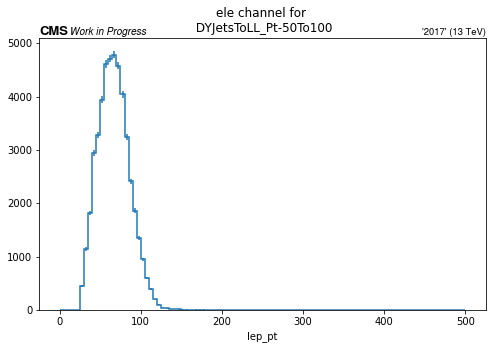

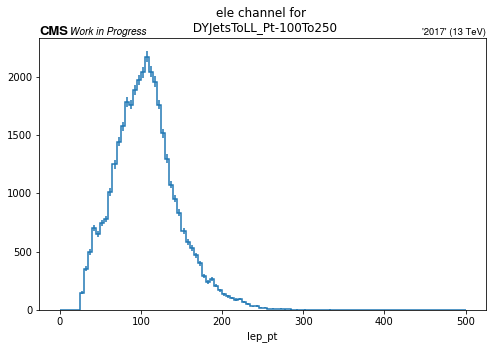

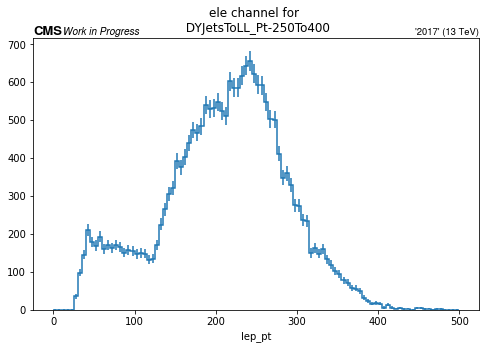

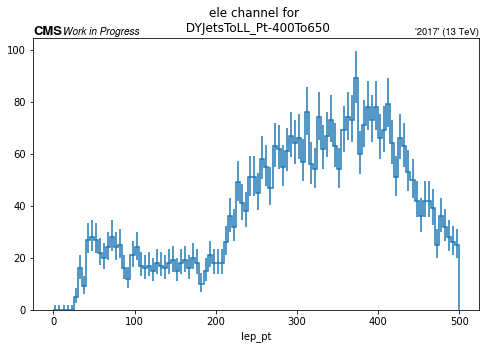

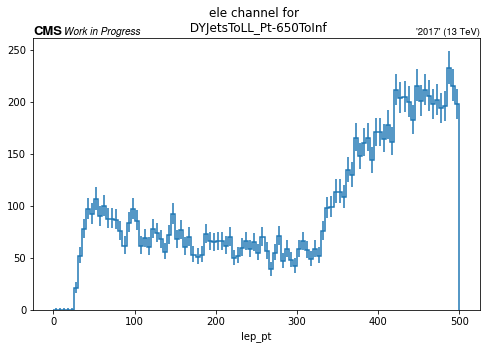

In [6]:
for flag in flags:
    h = hist2.Hist(
        hist2.axis.Regular(100,0, 500, name='lep_pt', label='lep_pt', flow=True),
    )
    h.fill(data[flag]['ele']['lep_pt']
          )

    odir = flag + '/jets'
    fig, ax = plt.subplots(figsize=(8, 5))
    hep.histplot(h, ax=ax)
    # ax.set_xlabel(f"{'btag_max'}")
    ax.set_title(f'ele channel for \n {flag}')
    hep.cms.lumitext(f"'2017' (13 TeV)", ax=ax)
    hep.cms.text("Work in Progress", ax=ax)

    if not os.path.exists(f'{odir}/'):
        os.makedirs(f'{odir}/')

    plt.savefig(f'{odir}/lep_pt_wth_btag_threshold.pdf')
## 1D-histograms with single axis:    plt.close()

## 1D-histograms stacked:

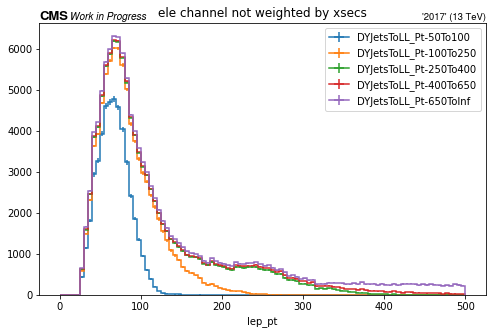

In [7]:
# stacked
h = hist2.Hist(
    hist2.axis.Regular(100,0, 500, name='lep_pt', label='lep_pt', flow=True),
    hist2.axis.StrCategory([], name='PT bin', label=flag, growth=True),
)
for flag in flags:
    h.fill(data[flag]['ele']['lep_pt'], flag
          )

odir = './all/'

fig, ax = plt.subplots(figsize=(8, 5))
hep.histplot([h[{"PT bin": flag}] for flag in flags], stack=True, ax=ax, label=[flag for flag in flags])
ax.set_title(f'ele channel not weighted by xsecs')
hep.cms.lumitext(f"'2017' (13 TeV)", ax=ax)
hep.cms.text("Work in Progress", ax=ax)
ax.legend()

if not os.path.exists(f'{odir}/'):
    os.makedirs(f'{odir}/')

plt.savefig(f'{odir}/lep_pt_stacked_noxsecs.pdf')
plt.show()
plt.close();

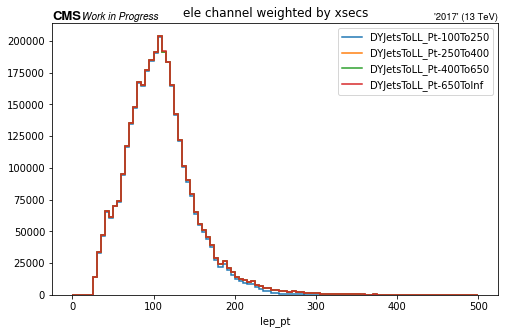

In [8]:
f = open('../fileset/xsec_pfnano.json')
xsec = json.load(f)
f.close()

flags = ["DYJetsToLL_Pt-100To250", "DYJetsToLL_Pt-250To400", "DYJetsToLL_Pt-400To650", "DYJetsToLL_Pt-650ToInf" ]

# stacked
h = hist2.Hist(
    hist2.axis.Regular(100,0, 500, name='lep_pt', label='lep_pt', flow=True),
    hist2.axis.StrCategory([], name='PT bin', label=flag, growth=True),
)
for flag in flags:
    h.fill(data[flag]['ele']['lep_pt'], flag, weight=eval(str((xsec[flag])))
          )

odir = './all/'

fig, ax = plt.subplots(figsize=(8, 5))
hep.histplot([h[{"PT bin": flag}] for flag in flags], stack=True, ax=ax, label=[flag for flag in flags])
ax.set_title(f'ele channel weighted by xsecs')
hep.cms.lumitext(f"'2017' (13 TeV)", ax=ax)
hep.cms.text("Work in Progress", ax=ax)
ax.legend()

if not os.path.exists(f'{odir}/'):
    os.makedirs(f'{odir}/')

plt.savefig(f'{odir}/lep_pt_stacked_xsecs.pdf')
plt.show()
plt.close();

## Apply cuts

In [113]:
# make the cuts
cuts = {}
for flag in flags:
    cuts[flag] = {}

    cuts[flag]['ele'] = {'all_but_dR_btag': (data[flag]['ele']['leptonKin']>40) & 
                                            (data[flag]['ele']['oneElectron']) &
                                            (data[flag]['ele']['notaus_ele']) &
                                            (data[flag]['ele']['ElectronIsolation']==1) &
                                            (data[flag]['ele']['mt_lep_met']==1),
                       'all_but_dR': (data[flag]['ele']['leptonKin']>40) & 
                                     (data[flag]['ele']['oneElectron']) &
                                     (data[flag]['ele']['notaus_ele']) &
                                     (data[flag]['ele']['ElectronIsolation']==1) &
                                     (data[flag]['ele']['mt_lep_met']==1) &
                                     (data[flag]['ele']['anti_bjettag']==1),
                       'all_but_btag': (data[flag]['ele']['leptonKin']>40) & 
                                       (data[flag]['ele']['oneElectron']) &
                                       (data[flag]['ele']['notaus_ele']) &
                                       (data[flag]['ele']['ElectronIsolation']==1) &
                                       (data[flag]['ele']['mt_lep_met']==1) &
                                       (data[flag]['ele']['leptonInJet']==1),
                       'all_cuts': (data[flag]['ele']['leptonKin']>40) & 
                                   (data[flag]['ele']['oneElectron']) &
                                   (data[flag]['ele']['notaus_ele']) &
                                   (data[flag]['ele']['ElectronIsolation']==1) &
                                   (data[flag]['ele']['mt_lep_met']==1) &
                                   (data[flag]['ele']['leptonInJet']==1) &
                                   (data[flag]['ele']['anti_bjettag']==1)
                        }

In [124]:
cut_types = ['all_cuts', 'all_but_btag', 'all_but_dR', 'all_but_dR_btag']
for cut_type in cut_types:
    h = hist2.Hist(
        hist2.axis.Regular(50,0, 250, name='lepton_pt', label='lepton_pt', flow=True),
        hist2.axis.StrCategory([], name='PT bin', growth=True)
    )

    for flag in flags:
        d = data[flag]['ele']['lep_pt'] 
        d = d[cuts[flag]['ele'][cut_type]]

        h.fill(
            d, flag,
        )

    odir = './all'

    fig, ax = plt.subplots(figsize=(8, 5))
    hep.histplot([h[{"PT bin": flag}] for flag in flags], stack=True, ax=ax, label=[flag for flag in flags])
    ax.set_xlabel(f"{'lep_pt'}")
    ax.set_title(f'ele channel after applying {cut_type} \n not weighted by xsecs')
    hep.cms.lumitext(f"2017 (13 TeV)", ax=ax)
    hep.cms.text("Work in Progress", ax=ax)
    ax.legend()

    if not os.path.exists(f'{odir}/'):
        os.makedirs(f'{odir}/')

    plt.savefig(f'{odir}/after_{cut_type}_noxsecs.pdf')
#     plt.close()    

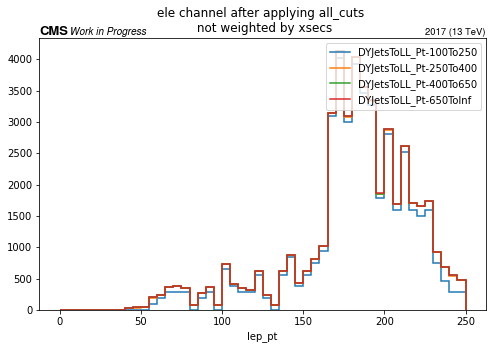

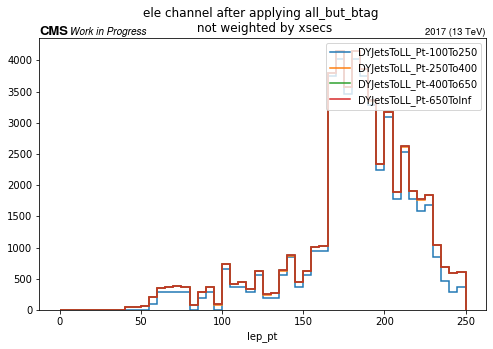

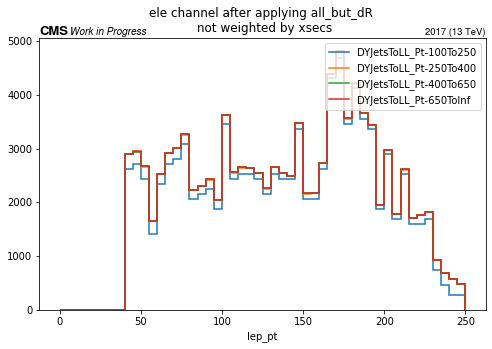

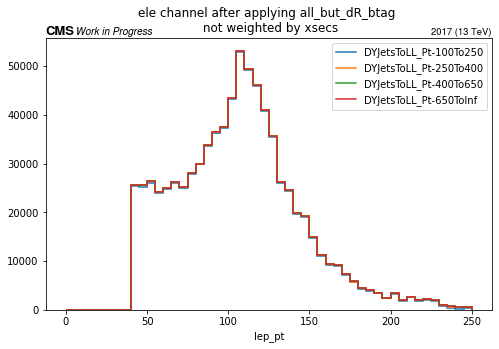

In [125]:
f = open('../fileset/xsec_pfnano.json')
xsec = json.load(f)
f.close()

flags = ["DYJetsToLL_Pt-100To250", "DYJetsToLL_Pt-250To400", "DYJetsToLL_Pt-400To650", "DYJetsToLL_Pt-650ToInf" ]

cut_types = ['all_cuts', 'all_but_btag', 'all_but_dR', 'all_but_dR_btag']
for cut_type in cut_types:
    h = hist2.Hist(
        hist2.axis.Regular(50,0, 250, name='lepton_pt', label='lepton_pt', flow=True),
        hist2.axis.StrCategory([], name='PT bin', growth=True)
    )

    for flag in flags:
        d = data[flag]['ele']['lep_pt'] 
        d = d[cuts[flag]['ele'][cut_type]]

        h.fill(
            d, flag, weight=eval(str((xsec[flag])))
        )

    odir = './all'

    fig, ax = plt.subplots(figsize=(8, 5))
    hep.histplot([h[{"PT bin": flag}] for flag in flags], stack=True, ax=ax, label=[flag for flag in flags])
    ax.set_xlabel(f"{'lep_pt'}")
    ax.set_title(f'ele channel after applying {cut_type} \n not weighted by xsecs')
    hep.cms.lumitext(f"2017 (13 TeV)", ax=ax)
    hep.cms.text("Work in Progress", ax=ax)
    ax.legend()

    if not os.path.exists(f'{odir}/'):
        os.makedirs(f'{odir}/')

    plt.savefig(f'{odir}/after_{cut_type}_noxsecs.pdf')
    # plt.close()    

## 2D-plot

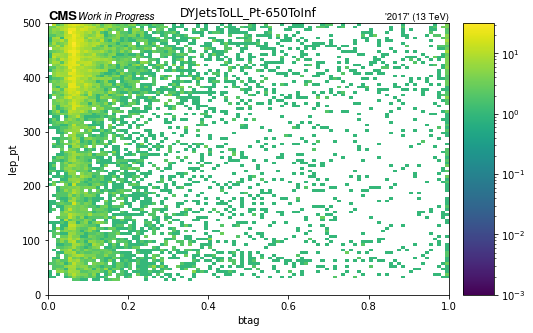

In [126]:
# Z_pt vs lep_Z_dr
h = hist2.Hist(
    hist2.axis.Regular(100,0, 1, name='btag', label='btag', flow=True),
    hist2.axis.Regular(100,0, 500, name='lep_pt', label='lep_pt', flow=True),
    hist2.axis.StrCategory([], name='PT bin', growth=True),
)

# for flag in flags:
h.fill(data[flag]['ele']['jets_outside_btag_max'], data[flag]['ele']['lep_pt'], flag
)

odir = './all/'

fig, ax = plt.subplots(figsize=(8, 5))
hep.hist2dplot(h[{"PT bin": flag}], ax=ax, norm=matplotlib.colors.LogNorm(vmin=1e-3))    
ax.set_title(f'{flag}')
hep.cms.lumitext(f"'2017' (13 TeV)", ax=ax)
hep.cms.text("Work in Progress", ax=ax)


if not os.path.exists(f'{odir}/'):
    os.makedirs(f'{odir}/')

plt.savefig(f'{odir}/btag_vs_lep_pt.pdf')
